A/B testing is a statistical technique in which we compare the outcomes of two groups (Group A and Group B). Group A is the control group (where no change has been made), and Group B is the variant group (where a new feature or change has been applied).

Goal: To check whether the change (variant) has had any meaningful impact on user behavior or performance metrics (like conversion rate).

Dataset Description:

Udacity tested a redesign of an enrollment page on their website through an A/B test.

Group A (control): Old page design

Group B (experiment): New page design

Goal: Does the new page improve the conversion rate (enrollments)?

Columns:



| Column Name    | Description                     |
| -------------- | ------------------------------- |
| `user_id`      | Unique user ID                  |
| `timestamp`    | Time of page visit              |
| `group`        | A or B (control or experiment)  |
| `landing_page` | old\_page or new\_page          |
| `converted`    | 1 if user enrolled, 0 otherwise |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Set styles
sns.set(style="whitegrid")

In [3]:
# Load data
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Filter for valid group/landing_page combinations
df_clean = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')").copy()

In [5]:
# Drop duplicate users
df_clean.drop_duplicates(subset='user_id', inplace=True)

In [6]:
# Convert timestamp to datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

In [7]:
df_clean.shape

(290584, 5)

In [8]:
# Conversion rate per group
conversion_rates = df_clean.groupby('group')['converted'].mean()
conversion_counts = df_clean.groupby('group')['converted'].agg(['sum', 'count'])

In [9]:
print("Conversion Rates:")
print(conversion_rates)

Conversion Rates:
group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


In [10]:
print("\nCounts:")
print(conversion_counts)


Counts:
             sum   count
group                   
control    17489  145274
treatment  17264  145310


In [11]:
# Daily conversion rate
df_clean['date'] = df_clean['timestamp'].dt.date
daily_conv = df_clean.groupby(['date', 'group'])['converted'].mean().unstack()

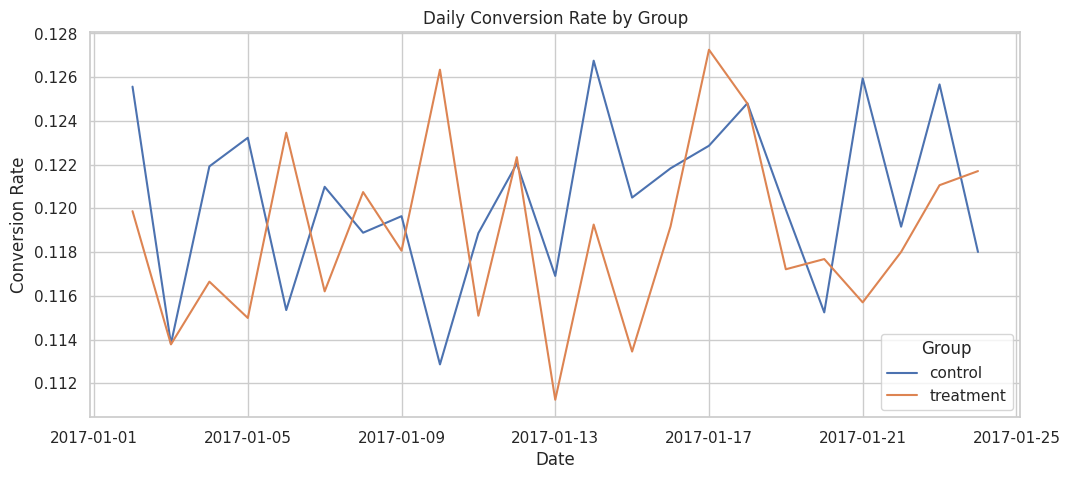

In [12]:
# Plot
daily_conv.plot(figsize=(12, 5))
plt.title("Daily Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Date")
plt.legend(title='Group')
plt.show()

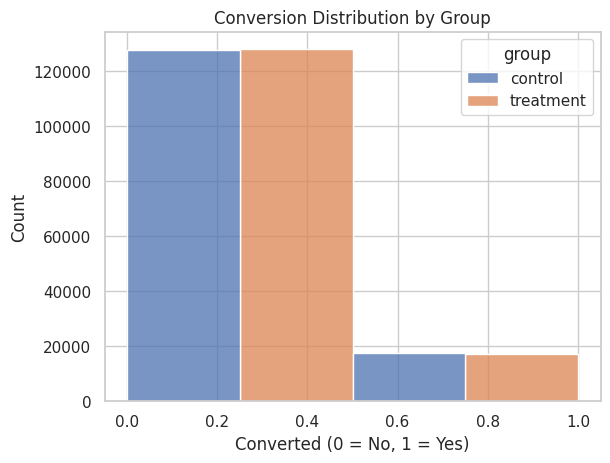

In [13]:
sns.histplot(data=df_clean, x="converted", hue="group", multiple="dodge", bins=2)
plt.title("Conversion Distribution by Group")
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.show()

In [14]:
# Z-Test for Statistical Significance
converted = df_clean.groupby('group')['converted'].sum()
n_obs = df_clean.groupby('group')['converted'].count()

z_score, p_value = proportions_ztest(count=converted, nobs=n_obs)
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

Z-score: 1.3109
P-value: 0.1899


In [18]:
print("Key Insights:")

print(f"\n Control Group Conversion Rate: {conversion_rates['control']:.4%}")
print(f"Treatment Group Conversion Rate: {conversion_rates['treatment']:.4%}")
print(f"Difference: {(conversion_rates['treatment'] - conversion_rates['control']):.4%}")

if p_value < 0.05:
    print("\n There is a statistically significant difference between the two groups.")
    if conversion_rates['treatment'] > conversion_rates['control']:
        print("New landing page improved conversions. You should consider rolling it out.")
    else:
        print("New landing page performed worse. Stick with the old one.")
else:
    print("\n No statistically significant difference found.")
    print("Recommendation: Keep the old page or test a different variation.")


Key Insights:

 Control Group Conversion Rate: 12.0386%
Treatment Group Conversion Rate: 11.8808%
Difference: -0.1578%

 No statistically significant difference found.
Recommendation: Keep the old page or test a different variation.


In [16]:
# Are users evenly distributed?
group_sizes = df_clean['group'].value_counts()
print("Group Size Distribution:")
print(group_sizes)

# Percentage distribution
(group_sizes / df_clean.shape[0]) * 100

Group Size Distribution:
group
treatment    145310
control      145274
Name: count, dtype: int64


,count
group,
treatment,50.006194
control,49.993806


In [17]:
# Check users with multiple entries
user_counts = df_clean['user_id'].value_counts()
repeat_users = user_counts[user_counts > 1]
print(f"Number of duplicate users in cleaned data: {repeat_users.shape[0]}")

Number of duplicate users in cleaned data: 0
